<img src="../img/GTK_Logo_Social Icon.jpg" width=175 align="right" />


# Worksheet 6.0 Clustering - Answers

This worksheet covers concepts relating to Unsupervised Learning.  It should take no more than 20-30 minutes to complete.  Please raise your hand if you get stuck.  

There are many ways to accomplish the tasks that you are presented with, however you will find that by using the techniques covered in class, the exercises should be relatively simple. 

## Import the Libraries
For this exercise, we will be using:
* Pandas (https://pandas.pydata.org/pandas-docs/stable/)
* Numpy (https://docs.scipy.org/doc/numpy/reference/)
* Matplotlib (https://matplotlib.org/stable)


In [104]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
from matplotlib import style
from scipy.spatial.distance import cdist
style.use("ggplot")
%matplotlib inline

# Clustering with Real Data
Let's try it on some real data and see what we can produce. As before the first step is to read in the data into a DataFrame.  

We will be using this data later, but the dataset consists of approximately 6000 domains--5000 of which were generated by various botnets and 1000 are from the Alexa 1 Million.  The columns are:

* `dsrc`:  The source of the domain
* `domain`:  The actual domain
* `length`:  The length of the domain
* `dicts`:  Percentage containing dictionary words
* `entropy`:  The entropy of the domain
* `numbers`:  The number of digits in the domain
* `ngram`:  Different n-grams which appear in the domain (?)

In [66]:
data = pd.read_csv('../data/dga-full.csv')
data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram
51067,alexa,trtsp,5,1.000000,1.921928,0,2.120574
46877,alexa,laurenconrad,12,1.000000,3.084963,0,12.983658
2080,bamital,4078a90ab0c23784e37333d4f340cceb,32,0.093750,3.468139,21,1.556303
5909,cryptolocker,ncvmxgvomvbd,12,0.583333,3.022055,0,0.000000
7051,cryptolocker,uadkuoacacpllxe,15,0.733333,3.189898,0,1.707570


In [67]:
data['dsrc'].value_counts()

cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: dsrc, dtype: int64

## Scaling the Data
Since clustering relies on measuring distances between objects it is important that all data points be on the same scale.  There are various methods for doing this, which are beyond the scope of this class, however, for this example, we will use scikit-learn's `StandardScaler` to accomplish this.  (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

The StandardScaler transforms each column by:
* Subtracting from the element in each row the mean for each feature (column) and then taking this value and
* Dividing by that feature's (column's) standard deviation.

Scikit-learn has a transformer interface which is very similar to the other scikit-learn interfaces.  The basic steps are:
1.  Create the Scaler object
2.  Using the feature matrix, call the `.fit()` method to "train" the Scaler
3.  Use the `.transform()` method to scale the data.

**NOTE**: When using a Scaler, it is important to train the scaler on your data, and use this trained scalers on any future predictions. 

In [68]:
feature_columns = ['length', 'dicts','entropy','numbers','ngram']
scaled_feature_columns = ['scaled_length', 'scaled_dicts','scaled_entropy','scaled_numbers','scaled_ngram']

In [69]:
#Step 1:  Create the scaler
scaler = StandardScaler()

#Steps 2 & 3:  Fit the scaler and transform this data
scaled_df = scaler.fit_transform(data[feature_columns])

#Put the scaled data into a dataframe
scaled_df = pd.DataFrame(scaled_df, columns=scaled_feature_columns)

Take a look at the data and you'll see that the data is now all scaled consistently. 

In [70]:
scaled_df.sample(10)

,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
8815,-0.408407,-0.917330,0.318839,-0.498385,-0.269274
34779,-0.802191,1.144799,-0.492925,-0.498385,0.494579
21379,1.429253,-0.547204,1.236128,1.210521,-0.722434
27479,-1.064714,-0.426347,-1.720726,-0.498385,-0.722434
3365,-0.145884,0.162833,0.743533,-0.498385,-0.609769
33831,-0.802191,1.144799,-0.876255,-0.498385,1.259287
42193,-0.670930,1.144799,-0.192390,-0.498385,1.549473
32746,-0.933453,1.144799,-0.833959,-0.498385,0.487873
47085,-1.327237,0.044997,-1.572375,-0.118628,-0.811719
7642,-0.277145,0.298797,0.540150,-0.498385,-0.300400


Finally for convenience, we're going to merge the scaled data with the non-scaled data.  

In [71]:
final_data = pd.merge( data, scaled_df, left_index=True, right_index=True)

In [72]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram
12031,cryptolocker,nqvyvmvdqmgnl,13,0.461538,2.873141,0,0.000000,-0.277145,-0.335704,-0.621544,-0.498385,-0.811719
3337,cryptolocker,grpmwyjxxwvlxm,14,0.214286,3.182006,0,0.000000,-0.145884,-1.015526,-0.088757,-0.498385,-0.811719
46522,alexa,startaid,8,1.000000,2.500000,0,12.557708,-0.933453,1.144799,-1.265204,-0.498385,1.538234
38435,nivdort,spokehour,9,1.000000,2.947703,0,7.926631,-0.802191,1.144799,-0.492925,-0.498385,0.671610
28764,necurs,mnvfdmq,7,0.428571,2.521641,0,0.000000,-1.064714,-0.426347,-1.227875,-0.498385,-0.811719


### Your Turn!
Now that we have data that is suitable (maybe) for clustering, in the section below, perform K-Means clustering on this data set.  Initially, start out with 2 clusters and assign the `cluster id` as a column in your DataFrame.

Then do a `value_counts()` on the `dsrc` column for each cluster to see how the model divided the data.  Try various values for `k` to see how it performed.

Remember to use the **scaled features** for your clustering.  

In [73]:
## Your code here...

kmeans = KMeans(n_clusters=2, n_init=2).fit(final_data[scaled_feature_columns])

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[-0.49772765  0.3717732  -0.38865348 -0.4893526   0.20118368]
 [ 1.56870839 -1.17173264  1.22493491  1.54231241 -0.63407876]]
[1 1 1 ... 0 0 0]


In [74]:
final_data['dsrc'].value_counts()

cryptolocker    10000
gameoverdga     10000
necurs          10000
alexa           10000
nivdort          9978
bamital          2500
Name: dsrc, dtype: int64

In [75]:
final_data['cluster_id'] = kmeans.labels_

In [76]:
final_data['cluster_id'].value_counts()

0    39842
1    12636
Name: cluster_id, dtype: int64

In [77]:
final_data[final_data['cluster_id'] == 1]['dsrc'].value_counts()

gameoverdga    9993
bamital        2500
necurs          140
alexa             3
Name: dsrc, dtype: int64

In [78]:
final_data[final_data['cluster_id'] == 0]['domain'].sample(5)

49073     omegawatches
39793        cloudaunt
5595     pjyuqgyqlriyn
25547      wedaklluccj
37862        wishraise
Name: domain, dtype: object

In [79]:
final_data['domain'][final_data['dsrc'] == 'cryptolocker'].sample(5)

4539      ochaerdaivjqf
4004       cdnidiktifhc
2886       khpedwdweema
4393     jabnleibhmdtdl
3243    ltmfrcoukcjpmmt
Name: domain, dtype: object

In [80]:
final_data[final_data['dsrc'] == "bamital"]['domain'].sample(10)

1446    a3a8e1cbc7be91d6ca4897f0af24c6fa
2130    aa246d230f40a0b43996b468e42700f5
225     30a9d94948205b92a29910d45421b4a7
970     eb8a4339882856d7c8b5442bc5b3d766
2367    5a146c31742e7d60d9e61e1873b82523
1386    2c20896a3d5cf6275c6af18fc26f8f61
1411    c8349b53026bd0f46759610578fb0adb
1910    a3d367b3175dfc1653f905ee774dfd6e
412     845c403353e425e72d1a4b1bbae92542
1240    a90a4d2ce0c772c83dbc1b8224e823ae
Name: domain, dtype: object

In [81]:
final_data[final_data['dsrc'] == "nivdort"]['domain'].sample(10)

38841      humanpure
36778       lordgrow
41747       gladfive
39769      quickaunt
35045       joinlive
36693       casehelp
34001      frontshow
37120       ablehurt
33313    spokeweight
33398       thisroll
Name: domain, dtype: object

In [82]:
final_data[(final_data['cluster_id'] == 1) & (final_data['dsrc'] == 'necurs')]['domain']

22546    kujnifxvqwkpyytegqohv
22632     xwhqnkkesylwbydfnsxm
22711       wuiioaeyklhgcxwmad
22736       efkwmijhtpxsgrhfgq
22743      shngncqtfjlfhdjrtks
                 ...          
31897    pyskufklybvjhfpywtvlc
31956      ixhlkocwfwwdktjmdvj
32246     sxgkkqnnfjsoyhebpypw
32434    cqvkgxsntoevqbkxnyvyf
32456    qxvbbtlxhwguongdywukl
Name: domain, Length: 140, dtype: object

In [83]:
final_data.sample(5)

,dsrc,domain,length,dicts,entropy,numbers,ngram,scaled_length,scaled_dicts,scaled_entropy,scaled_numbers,scaled_ngram,cluster_id
28011,necurs,drkxhfvqu,9,0.000000,3.169925,0,0.000000,-0.802191,-1.604706,-0.109596,-0.498385,-0.811719,0
73,bamital,02c7ee2ee3f166e80143f2c5ed59ade2,32,0.093750,3.635891,18,1.653213,2.216822,-1.346940,0.694187,2.919427,-0.502349,1
2783,cryptolocker,bmlgdauahpsvp,13,0.846154,3.392747,0,0.000000,-0.277145,0.721798,0.274768,-0.498385,-0.811719,0
11834,cryptolocker,rlagfkvbhvnfi,13,0.461538,3.392747,0,2.334454,-0.277145,-0.335704,0.274768,-0.498385,-0.374867,0
35450,nivdort,trieddare,9,1.000000,2.503258,0,8.888061,-0.802191,1.144799,-1.259584,-0.498385,0.851525,0


## Food for thought:
Now that you've done clustering with various numbers of clusters, it appears that the data acutally does break evenly into 2 clusters.  Take a look at the original data and see if you can come up with a reason why that is the case.

## Visualizing Performance
As we already know, it is difficult to measure the performance of clustering models since there usually is no known ground truth from which to evaluate your model.  However, there are two techniques which 

The K-Elbow Visualizer implements the “elbow” method of selecting the optimal number of clusters for K-means clustering. K-means is a simple unsupervised machine learning algorithm that groups data into a specified number (k) of clusters. Because the user must specify in advance what k to choose, the algorithm is somewhat naive – it assigns all members to k clusters even if that is not the right k for the dataset.

The elbow method runs k-means clustering on the dataset for a range of values for k (say from 1-10) and then for each value of k computes an average score for all clusters. By default, the distortion_score is computed, the sum of square distances from each point to its assigned center. Other metrics can also be used such as the silhouette_score, the mean silhouette coefficient for all samples or the calinski_harabaz_score, which computes the ratio of dispersion between and within clusters.

When these overall metrics for each model are plotted, it is possible to visually determine the best value for K. If the line chart looks like an arm, then the “elbow” (the point of inflection on the curve) is the best value of k. The “arm” can be either up or down, but if there is a strong inflection point, it is a good indication that the underlying model fits best at that point. (http://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

In python there is a module called `YellowBrick` which facilitates visualizing the K-Elbow score.  All of YellowBrick's visualizations follow essentually the same pattern:

1.  Create the Visualizer Object
2.  Call the `.fit()` method using the data
3.  Call the `.show()` method to render the visualization

The snippet below demonstrates how to use the elbow method to visualize the clustering model's performance on this dataset.
```python
visualizer = KElbowVisualizer(KMeans(), k=(4,12))

visualizer.fit( feature_matrix ) 
visualizer.show()
```

### Your Turn!
In the box below, create a visualization using the elbow method to see if there are any inflection points in the distortion score.

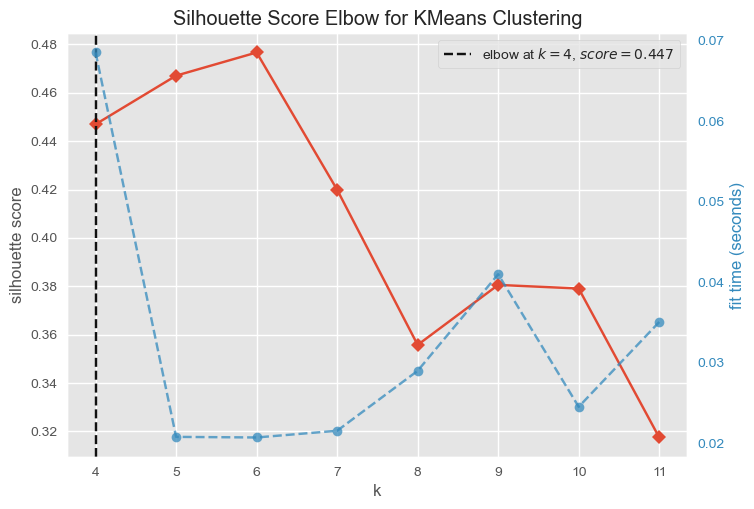

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [84]:
# Your code here...
visualizer = KElbowVisualizer( KMeans(n_init=2), k=(4,12), metric='silhouette')

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Another Way to Visualize Clustering Performance
The Silhouette Coefficient is used when the ground-truth about the dataset is unknown and computes the density of clusters computed by the model. The score is computed by averaging the silhouette coefficient for each sample, computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between 1 and -1, where 1 is highly dense clusters and -1 is completely incorrect clustering. (http://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)


### Your Turn!
Using the YellowBrick `SilhouetteVisualizer`, try visualizing models with various values of `K`.

**Note**:  This visualization is quite expensive, so I recommend performing this using a sample o your original data.

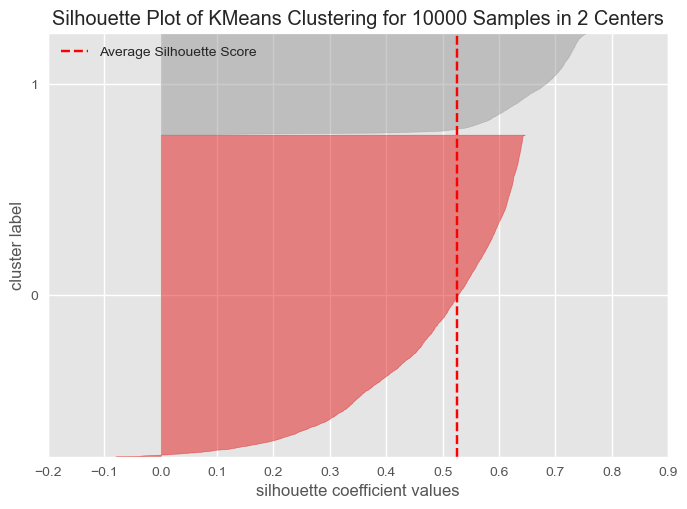

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [126]:
# Your code here...
visualizer = SilhouetteVisualizer( KMeans(n_clusters=2, n_init=3))

visualizer.fit(final_data[scaled_feature_columns].sample(10000))
visualizer.show()

## Anomaly Detection using Clustering methods
Let's use a hierarchical clustering method to detect anomalies in a set of data points. The one we will use is called (agglomerative clustering)[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html]. 

First we will create a dataset that only has 20 DGA rows and 1000 legit samples. Thus, there are 20 anomalies in this dataset that we know of. Then we will see if our clustering method can detect them. 

In [114]:
dga_data = pd.read_csv('../data/our_data_dga_features_final_df.csv')

print(dga_data.isDGA.value_counts())

1    1000
0    1000
Name: isDGA, dtype: int64


In [115]:
is_dga = dga_data[dga_data['isDGA']==1].sample(10)
not_dga = dga_data[dga_data['isDGA']==0]

In [116]:
print(len(is_dga))
print(len(not_dga))

10
1000


In [117]:
dga_anomaly_data = pd.concat([is_dga, not_dga])
dga_anomaly_data['isDGA'].value_counts()

0    1000
1      10
Name: isDGA, dtype: int64

#### Now use this dataset in clustering

First we want to scale the data because it is clustering which means that distance is important and that is extremely sensitive to different scales. Use either the Standard Scaler or Min Max Scaler from sklearn to scale our data set.

In [118]:
dga_anomaly_data  = StandardScaler().fit_transform(dga_anomaly_data)

Now that we have prepared the data, we can put it into a model. Call the Agglomerative Clustering model from sklearn and fit it to the data. name the model **agglomerative_clust**

In [120]:
agglomerative_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

# Your code here
agglomerative_clust = agglomerative_clust.fit(dga_anomaly_data)

# pull out the label of the cluster each point belongs to. 
labels_for_clusters = agglomerative_clust.labels_

This plot_dendrogram function will plot the dendrogram for the cluster model you just fitted to the data. 

In [102]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Use the plot_dendrogram function to plot the dendrogram. You an get lower and lower levels if you increase the value of **p**. Try plotting a few values of **p** to see the difference and notice what happens.

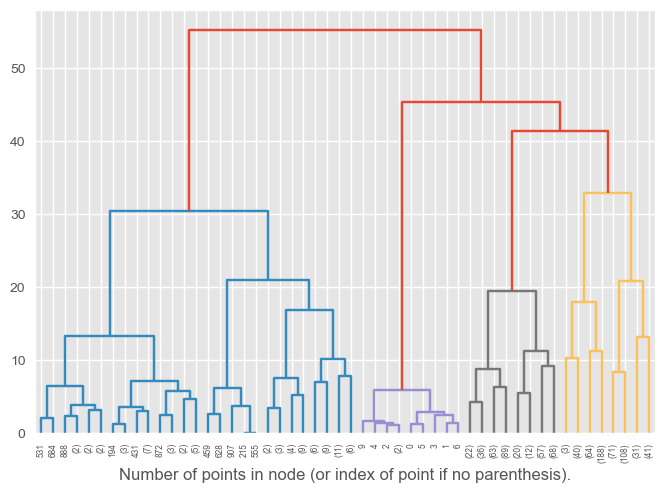

In [121]:
plot_dendrogram(agglomerative_clust, truncate_mode="level", p=5);
plt.xlabel("Number of points in node (or index of point if no parenthesis).");


Notice that in the plot there are some digits on the x-axis with no parenthesis. These are nodes that did not have more than 1 data point. We want to take a look at these because they are 'far' enough away from the rest of the data to warrant their own node, and thus could be an anomaly. 

Below, use the original pandas data frame to print the rows of the single nodes and see if these are our few DGAs. 

In [122]:
dga_data.iloc[0,:]

isDGA                1.000000
length              13.000000
digits               0.000000
entropy              0.443324
vowel-cons           0.083333
firstDigitIndex      0.000000
ngrams             744.670940
Name: 0, dtype: float64

In [123]:
dga_data.iloc[5,:]

isDGA                1.000000
length              12.000000
digits               0.000000
entropy              0.427287
vowel-cons           0.090909
firstDigitIndex      0.000000
ngrams             690.387879
Name: 5, dtype: float64

In [124]:
dga_data.iloc[1,:]

isDGA                1.000000
length              26.000000
digits              10.000000
entropy              0.516618
vowel-cons           0.333333
firstDigitIndex      1.000000
ngrams             715.217265
Name: 1, dtype: float64

In [125]:
dga_data.iloc[3,:]

isDGA                1.000000
length              26.000000
digits               7.000000
entropy              0.522604
vowel-cons           0.357143
firstDigitIndex      1.000000
ngrams             682.269402
Name: 3, dtype: float64

Another thing to note is just to look at the contents of the smallest cluster (depending on how small you think your anomalies are. IN this case our smallest cluster contains the DGAs. Thus, our model accurately pulled out the DGAs into their own 'anomaly' cluster. 

## DBSCAN
Another clustering method we can try is DBSCAN (http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).  Remember that the main tuning parameters for DBSCAN are:

* **epsilon (eps)**:  The minimum distance between two samples 
* **min_samples**:  The minimum number of samples needed to form a neighborhood

By default epsilon is 0.5 and the min_samples is 5. First, try DBSCAN with the default options.  If you use the `fit_predict()` function, you can save the results in a new column in your data.  

How did this compare with K-Means?  Given that you actually know what the data really is, how did DBSCAN do in terms of identifing meaningful clusters?  Look at the `dsrc` column and do `value_counts()` for the various neighhborhoods.  What did you notice?

Try again, but this time experiment with the values of epsilon and min_samples and see what DBSCAN comes up with. 

In [23]:
dbscan = DBSCAN(min_samples=50)

In [24]:
final_data['dbs_default'] = dbscan.fit_predict(final_data[scaled_feature_columns])

In [25]:
final_data['dbs_default'].value_counts()

 1    39301
 2     9973
 0     2500
-1      284
 4      259
 3      116
 5       45
Name: dbs_default, dtype: int64

In [26]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [27]:
final_data[final_data['dbs_default'] == 1 ][['dsrc','domain']].sample(10)

,dsrc,domain
9446,cryptolocker,xvbnapiywfagvt
23140,necurs,huwvtreromwta
2731,cryptolocker,hufqjcrmgchih
41248,nivdort,whomwhole
35529,nivdort,thesefeel
6953,cryptolocker,bdtakobikoni
5404,cryptolocker,xiuadnbellohhw
28650,necurs,ngqhqqbduvjkdr
38321,nivdort,dreamgrow
7461,cryptolocker,lligwhttuxyqir


In [28]:
final_data[final_data['dbs_default'] == -1 ]['dsrc'].sample(10)

50809      alexa
49624      alexa
51698      alexa
43531      alexa
52446      alexa
2405     bamital
46545      alexa
47868      alexa
52264      alexa
49046      alexa
Name: dsrc, dtype: object

In [29]:
final_data['domain'][final_data['dsrc'] == "nivdort"].sample(5)

40241    drinkvoice
42410     fairfruit
39274      rockslow
38547      gladjune
40724     headthrow
Name: domain, dtype: object

In [30]:
final_data[final_data['dbs_default'] == 2 ]['dsrc'].value_counts()

gameoverdga    9973
Name: dsrc, dtype: int64

In [31]:
final_data[final_data['dbs_default'] == 1 ]['dsrc'].value_counts()

cryptolocker    10000
necurs           9990
nivdort          9978
alexa            9330
gameoverdga         3
Name: dsrc, dtype: int64

In [32]:
final_data[final_data['dsrc'] == "cryptolocker"]['domain'].sample(10)

10649       wbirarkhsfgf
8792        ffkwsvsieexl
11876      gkjsqegicfuxs
7565       btahdqypypsbp
12072     xjlepuhmjvycjt
8145     gxaakkrvirymuuk
11432    qnvysekkbpwpnmo
3825        qmvuvtftlhws
7031        hgttabqebluy
5041        iyiwxusxdvke
Name: domain, dtype: object

In [33]:
final_data[final_data['dsrc'] == "necurs"]['domain'].sample(10)

32316          ptgctebbvohb
31865    vwhilgweujpuliijvs
26512     ksyaqkudmuorqdsnx
30930           kmtleqvxqvk
24248     rtatnpxrleuyjfvmr
27666     rlgawlqrvgkskeisa
24989            uegqqmllfr
22616          defellojyrqw
22599            jhkoqfmwjo
26324     vrdimsspkhpbyvwjo
Name: domain, dtype: object